<a href="https://colab.research.google.com/github/Andrey239/ML_LPI_2021/blob/main/seminar05/MLatFIAN2021_seminar05_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [27]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics
from sklearn.model_selection import KFold

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [50]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]
    return self.best_feature_ids

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [51]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9199999999999999


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)

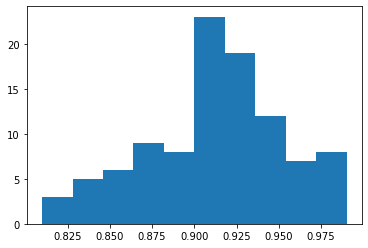

In [52]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)
  print(X_best.shape)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

Тут была какая-то проблема с тем как мы отбирали признаки. У нас они не были независимыми, так как мы их отбирали до крос валидации, передавая модели информацию. Если все сделать наоборот, должно работать

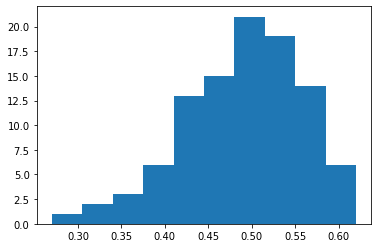

In [54]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  res = []
  kf = KFold(n_splits=10)
  for train, test in kf.split(X, y):
    
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    X_train_best = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
    best_feature_ids = FeatureSelector(num_features_best).fit(X_train, y_train)
   # print(best_feature_ids)
    X_test_best = X_test[:,best_feature_ids]
   # print(X_test.shape)
    model = LinearSVC()
    model.fit(X_train_best, y_train)
   # print(X_test_best.shape)
    y_pred = model.predict(X_test_best)
    accuracy = skmetrics.accuracy_score(y_test, y_pred)
    
    res.append(accuracy)
  return np.array(res).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

eh, decent enough